# Part 2: Model Inference

In this exercise you will implement gradient descent to optimize the driving force (or model potential) in the space of continuous functions.

In [ ]:
# Package installation - needed to run in google Collab. Comment this is you run the code locally 
!pip install git+https://github.com/engellab/neuralflow
    

In [1]:
# Import packages
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec

First, let us generate the data from ramping dynamics as in part 1.

In [2]:
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}},  
               'Nv': 111,  
               'peq_model':{"model": "linear_pot", "params": {"slope": -2.65}},
               'D0': 0.56,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'absorbing', 
               'num_neuron':2,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}},
                               {"model": "sinus", "params": {"bias": 50, "amp": 40}}],
               'verbose':True
               }

# Create the class instance for data generation (and call it em_gt, which means ground-truth energymodel)
em_gt=neuralflow.EnergyModel(**EnergyModelParams)

# Specify data generation parameters
num_trial = 50
data_gen_params={'deltaT':0.0001, 'time_epoch':  [(0,100)]*num_trial, 'last_event_is_spike':False}

#Generate the data
data, time_bins, diff_traj, metadata=em_gt.generate_data(**data_gen_params)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.94it/s]


Now initialize another class instance, em_fitting, which will be used for model optimization. This class instance will be the same as the ground-truth model, but with a different peq (constant peq, which implies uniform potential). Our goal is to find the correct model potential.

In [3]:
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}},  
               'Nv': 111,  
               'peq_model':{"model": "uniform", "params": {}},
               'D0': 0.56,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'absorbing', 
               'num_neuron':2,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}},
                               {"model": "sinus", "params": {"bias": 50, "amp": 40}}],
               'verbose':True
               }

em_fitting = neuralflow.EnergyModel(**EnergyModelParams)

 Now implement gradient descent. On each iteration, you will use our class method to calculate the negative loglikelihood and its variational derivative w.r.t. the driving force. Since this method requires peq to calculate the gradient, you will need to calculate the driving force from peq, update it, and then calculate the new peq which will be used to calculate the gradient and the negative loglikelihood on next iteration.

In [5]:
# Gradient-descent optimization of model potential
# Feel free to adjust these parameters and see how it will affect the result

# Number of gradient-descent iterations
number_of_iterations = 10

# Learning rate
gamma = 0.5

# last_event_is_spike should be set to False if we recorded the end of trial time.
# absorption_event is true if we want to apply the absorption operator in the end of the chain.
metadata = {'last_event_is_spike':False,'absorption_event':True}

# Allocate the arrays to store negative loglikelihoods and fitted peqs.
# Since we also want to store the initial guess, the size will be equal
# to the number of iterations + 1.
fitted_peqs = np.zeros((em_fitting.N,number_of_iterations+1))
logliks = np.zeros((number_of_iterations+1))

# Save the initial guess for peq
fitted_peqs[:,0]=em_fitting.peq_

# Extract the current framework parameters
peq_cur = fitted_peqs[:,0]
p0 = em_fitting.p0_
D = em_fitting.D_
fr = em_fitting.fr_

# Here rho0 is p0(x) scaled by sqrt(peq(x)). This quantitiy is needed for the gradient and likelihood 
# calculation. Whenever we update peq or p0, this quantitiy should also ne updated. See Supplementary
# Information for Genkin, Hughes, Engel ArXiv 2020 paper for mode details.
rho0 = p0 / np.sqrt(peq_cur) 


for i in range(number_of_iterations):
    print(f'Iteration {i}...')
    
    # Cacluate the gradient of negative loglik w.r.t. F(x), and also negative loglik
    res = em_fitting._get_loglik_data(data, metadata, peq_cur, rho0, D, fr, 'gradient', ['F'], None)
    dF = res['F']
    logliks[i] = res['loglik']
    
    # Calculate the force F(x) from peq. 
    F_old = em_fitting.dmat_d_.dot(np.log(peq_cur))
    
    # Now update the force with gradient-descent step using the learning rate gamma.
    # Note that we calculated the gradient of the cost function (negative loglik),
    # therefore we need to march in the direction negative to the gradient.
    
    ######INSERT YOUR CODE HERE############
    F_new = None - None
    #######################################
    
    # Update the current peq for the next iterations
    peq_cur = np.exp(em_fitting.Integrate(F_new))
    peq_cur /= np.sum(peq_cur * em_fitting.w_d_)
    
    # Update rho0
    rho0 = p0 / np.sqrt(peq_cur)
    
    # Save the current peq into fitted_peqs array
    
    ######INSERT YOUR CODE HERE############
    fitted_peqs[:,i+1] = peq_cur
    #######################################

# Calculate the final negative loglikelihood. 
logliks[number_of_iterations] = em_fitting.score(data,metadata,peq=peq_cur)
    

Iteration 0...
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...


Now, let us visualize the results. Note that the cost function should decrease on every iteration provided that the learning rate is small enough. If the cost function does not decrease consistently, you may try reducing the learning rate. Also feel free to increase the number_of_iterations in order to obtain more accurate results

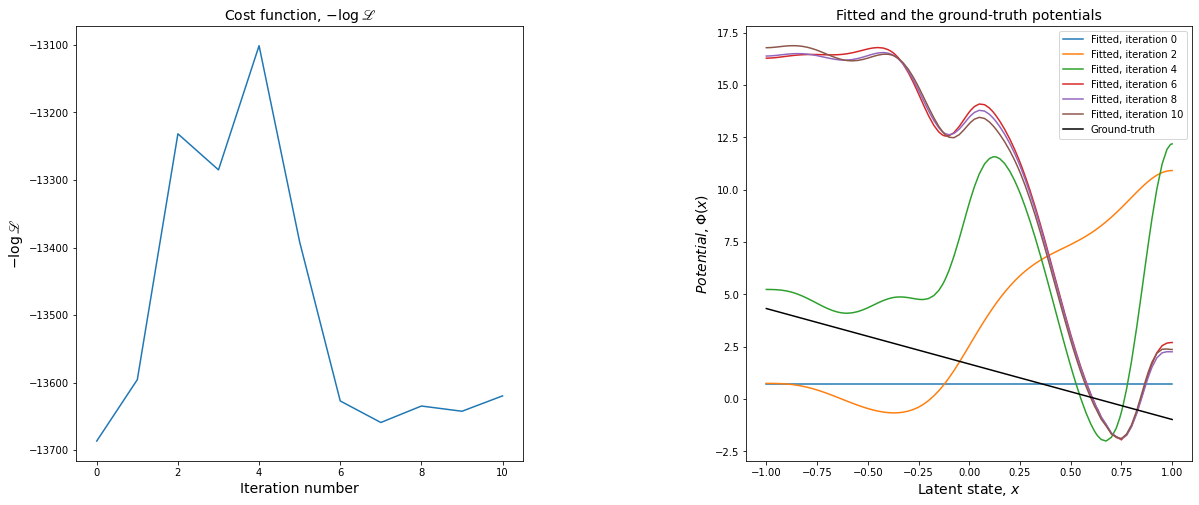

In [6]:
number_of_displayed_iterations = 6

fig=plt.figure(figsize=(20,8))
gs=gridspec.GridSpec(1,2,wspace=0.5,hspace=0.5);

ax = plt.subplot(gs[0])
ax.set_title(r'Cost function, $-\log\mathscr{L}$', fontsize=14)
plt.xlabel('Iteration number', fontsize=14)
plt.ylabel(r'$-\log\mathscr{L}$', fontsize=14)

ax.plot(np.array(range(number_of_iterations+1)),logliks)

ax = plt.subplot(gs[1])
ax.set_title(r'Fitted and the ground-truth potentials', fontsize=14)
plt.xlabel(r'Latent state, $x$', fontsize=14)
plt.ylabel(r'$Potential, \Phi(x)$', fontsize=14)

# Feel free to manually define display iterations
# For example, if you want to display the results at iterations 0,3,10,50, 
# set display_iteration = np.array([0,3,10,50]).astype(int) 
display_iteration = np.linspace(0,number_of_iterations,number_of_displayed_iterations).astype('int')

for i in display_iteration:
    plt.plot(em_fitting.x_d_,-np.log(fitted_peqs[:,i]),label=f'Fitted, iteration {i}')
plt.plot(em_gt.x_d_,-np.log(em_gt.peq_),label=f'Ground-truth',color='black')
plt.legend()

